In [1]:
import scipy
import numpy as np
from curves import *
from fivebar import FiveBar, GetTrajectory, Animate
from data import store_results
from IPython.display import HTML
import os 
import h5py
from joblib import Parallel, delayed
import timeit

dataset_path='fivebar_dataset.h5'

In [2]:
## Generate a dataset of trajectories for multiple 4bar linkages
lengths_sweep=np.linspace(0.1,5,4)
xx=np.meshgrid(lengths_sweep,lengths_sweep,lengths_sweep,lengths_sweep,lengths_sweep)
xx_flat = np.array([x.flatten() for x in xx]).transpose()

def process_point(xi):
    start_time = timeit.default_timer()
    fbar = FiveBar(1,*xi)
    traj, thetas = GetTrajectory(fbar)
    elapsed = timeit.default_timer() - start_time
    return traj, thetas,elapsed

start_time = timeit.default_timer()
results = Parallel(n_jobs=32)(delayed(process_point)(xx_flat[i,:]) for i in range(xx_flat.shape[0]))
trajectories, fks, exectimes = zip(*results)
elapsed = timeit.default_timer() - start_time

store_results(dataset_path, xx_flat, np.array(trajectories), np.array(fks))
print('Exectime:',elapsed)

Added results.
Exectime: 12.515873699914664


(np.float64(-0.3019906967878342),
 np.float64(0.3178843349218369),
 np.float64(-0.32159634977579116),
 np.float64(0.3314110592007637))

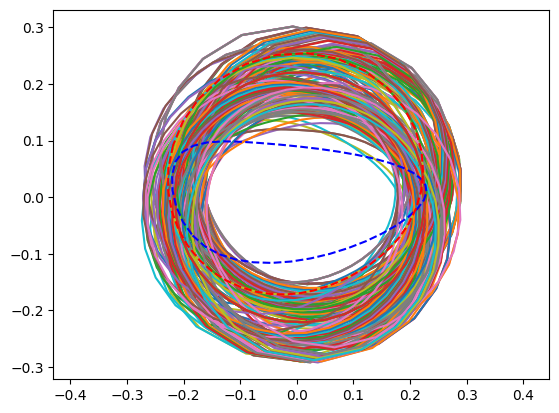

In [3]:
# Load the dataset and find the best trajectory
points = [[0,0], [3,0], [1,1], [0,1],[0,0]]
trajectory_star = ClosedSpline(points, n=40)
trajectory_star=np.stack([trajectory_star.xx,trajectory_star.yy],axis=1)
traj_star,_,_,_=NormalizeTrajectory(trajectory_star)

with h5py.File(dataset_path, "r") as f:
    params_ds = f["params"][:]
    traj_ds = f["trajectories"][:]
    fk_ds = f["fks"][:]
    er_ds = 1000*np.ones(params_ds.shape[0])
    for i in range(0,params_ds.shape[0]):
        traj=traj_ds[i,:,:]                
        if np.isnan(traj).any():
            continue
        if np.square(traj[0,:]-traj[-1,:]).sum()>1e-3:
            continue
        traj,_,_,_=NormalizeTrajectory(traj)
        er=CompareCurves(traj_star[:,0],traj_star[:,1],traj[:,0],traj[:,1])
        
        er_ds[i]=er
        plt.plot(traj[:,0],traj[:,1])
    plt.axis('equal')

idx=er_ds.argmin()
params_best=params_ds[idx,:]

plt.plot(traj_star[:,0],traj_star[:,1],'b--')
traj_best,_,_,_=NormalizeTrajectory(traj_ds[idx,:])
plt.plot(traj_best[:,0],traj_best[:,1],'r--')
plt.axis('equal')


In [ ]:
traj_star,center_star,scale_star,rotm_star=NormalizeTrajectory(trajectory_star)

def opt_fun(x):
    fourbar=FourBar(1,*x)            
    trajectory,_=GetTrajectory(fourbar)  
    if np.isnan(trajectory).any():
        er=1000        
    else:
        traj,_,_,_=NormalizeTrajectory(trajectory)
        er=CompareCurves(traj_star[:,0],traj_star[:,1],traj[:,0],traj[:,1])
    return er

x0=params_best
out_opt=scipy.optimize.least_squares(opt_fun,x0,bounds=([0.1,0.1,0.1],[5,5,5]),method='dogbox')

plt.plot(traj_star[:,0],traj_star[:,1],'b--')
fourbar=FourBar(1,*out_opt.x)    
trajectory,_=GetTrajectory(fourbar)
traj_best,center_best,scale_best,rotm_best=NormalizeTrajectory(trajectory)
plt.plot(traj_best[:,0],traj_best[:,1],'k--')
plt.axis('equal')

In [ ]:
# De-normalize the trajectory
tt=trajectory*scale_star/scale_best
rotm=np.matmul(rotm_best,rotm_star.T)
tt2=np.matmul(rotm,tt.T).T+center_star-np.matmul(rotm,center_best*scale_star/scale_best)
fourbar=FiveBar(scale_star/scale_best*1,*(scale_star/scale_best*out_opt.x))
offset=center_star-np.matmul(rotm,center_best*scale_star/scale_best)
fourbar.setOloc(*offset)
fourbar.setRot(1.80)

ani,fig=Animate(fourbar,trajectory_star)
plt.close(fig)
HTML(ani.to_jshtml())